In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import pickle
import os

In [2]:
#Call variables from data cleaning process
%store -r df
df = df

%store -r cat_columns
cat_columns = cat_columns

%store -r numeric_columns
numeric_columns = numeric_columns

# **1. Handling Outliers**

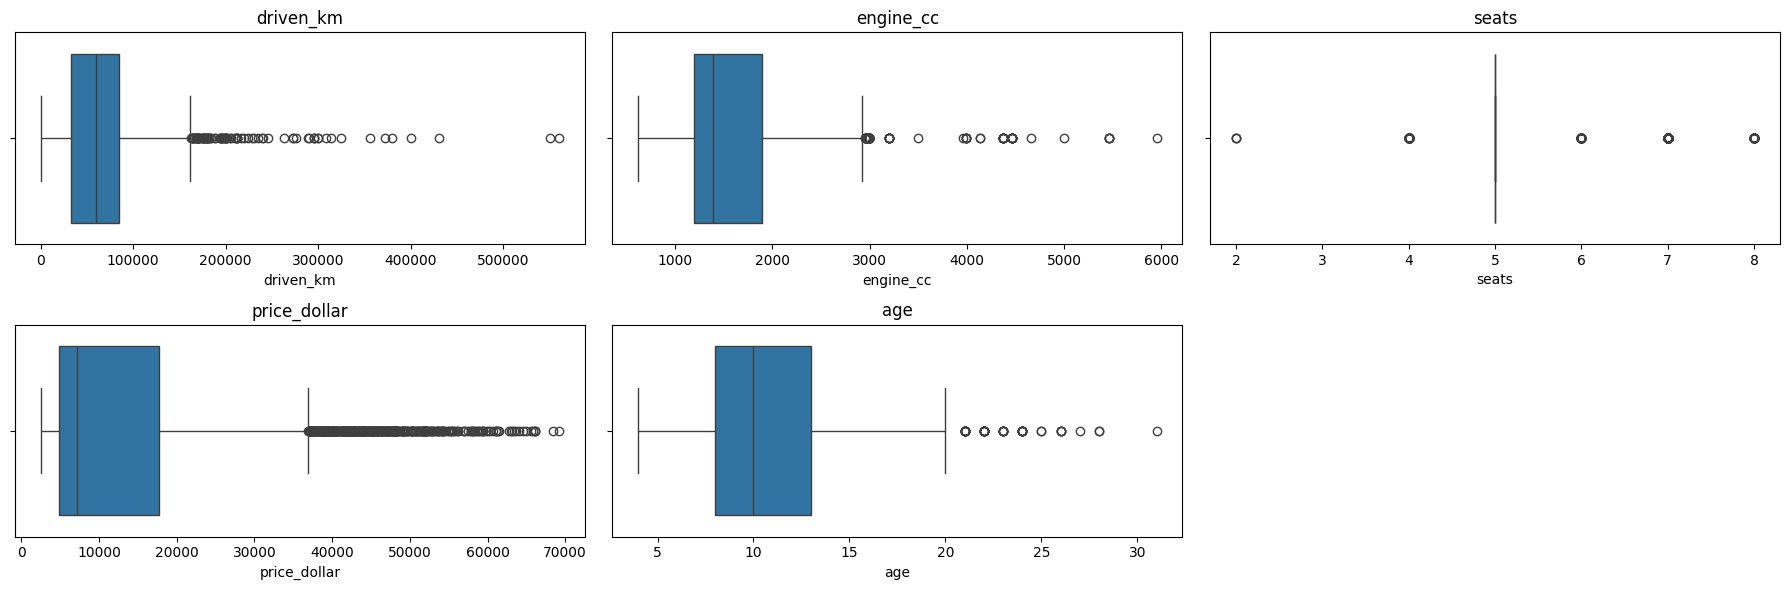

In [3]:
def box_plot(columns):
    # Create a grid of boxplots for numerical features
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 6))
    axes = axes.flatten()

    # Plot each numerical feature
    for i, col in enumerate(columns):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(col)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage
box_plot(numeric_columns[:6])

Boxplots reveal strong skewness and the presence of outliers across most numerical features. As a result, median-based statistics are preferred, and robust preprocessing choices are required to handle extreme values effectively. Therefore, outliers were retained and will be handled in transformations to reduce skewness and stabilize variance.

In [4]:
# Function to compute IQR-based lower and upper bounds for outlier detection
def iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    
    # Interquartile range
    IQR = Q3 - Q1
    
    # Define outlier boundaries using the 1.5 * IQR rule
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

In [5]:
# Compute IQR bounds for the target variable (price)
lower, upper = iqr_bounds(df["price_dollar"])

# Identify rows where price is outside the IQR bounds (outliers)
outliers_price = df[
    (df["price_dollar"] < lower) | (df["price_dollar"] > upper)
]
outliers_price.shape

(438, 9)

Price outliers were identified using the IQR rule, but retained since they represent valid high-end vehicles rather than noise

(496, 9) = 496 voitures à prix extrême
C’est normal pour un marché automobile

# **2. Categorical Encoding**

In [6]:
os.makedirs("../models", exist_ok=True)

# ownership : ordinal
ownership_mapping = {
    "0th Owner": 0,
    "1st Owner": 1,
    "2nd Owner": 2,
    "3rd Owner": 3,
    "4th Owner": 4,
    "5th Owner": 5
}

df["ownership_ord"] = df["ownership"].map(ownership_mapping)

with open("../models/ownership_encoder.pkl", "wb") as f:
    pickle.dump(ownership_mapping, f)


# transmission : binaire
transmission_mapping = {
    "Manual": 0,
    "Automatic": 1
}

df["transmission_bin"] = df["transmission"].map(transmission_mapping)

with open("../models/transmission_encoder.pkl", "wb") as f:
    pickle.dump(transmission_mapping, f)


In [7]:
# fuel_type : target encoding
global_median = df["price_dollar"].median()

alpha = 0.7  # poids de la catégorie
fuel_median = df.groupby("fuel_type")["price_dollar"].median()

df["fuel_te_reg"] = df["fuel_type"].map(
    alpha * fuel_median + (1 - alpha) * global_median
)

df["fuel_te_reg"] = df["fuel_te_reg"].fillna(global_median)

fuel_te_reg_dict = {
    "fuel_median": fuel_median.to_dict(),
    "global_median": global_median,
    "alpha": alpha
}

with open("../models/fuel_te_reg.pkl", "wb") as f:
    pickle.dump(fuel_te_reg_dict, f)

In [8]:
# brand : target encoding
brand_median = df.groupby("brand")["price_dollar"].median()

df["brand_te"] = df["brand"].map(brand_median)
df["brand_te"] = df["brand_te"].fillna(global_median)

with open("../models/brand_te.pkl", "wb") as f:
    pickle.dump(brand_median.to_dict(), f)

Category-level medians were combined with the global median using a smoothing parameter to prevent overfitting, especially for rare categories.

In [72]:
df.head()

,driven_km,fuel_type,transmission,ownership,engine_cc,seats,price_dollar,age,brand,ownership_ord,transmission_bin,fuel_te_reg,brand_te
1617,64000.0,Diesel,Automatic,1st Owner,2967.0,4,40500.0,10,Mercedes-Benz,1,1,9061.0,42835.0
3664,120000.0,Petrol,Manual,4th Owner,1086.0,7,4540.0,15,Honda,4,0,6429.0,6880.0
322,13000.0,Petrol,Automatic,1st Owner,2998.0,7,58670.0,7,BMW,1,1,6429.0,41250.0
4087,75000.0,Petrol,Manual,2nd Owner,998.0,5,3310.0,20,Maruti,2,0,6429.0,5650.0
5391,95790.0,Diesel,Manual,1st Owner,1799.0,8,25530.0,7,Mahindra,1,0,9061.0,9620.0


In [73]:
cols = [
    "price_dollar",
    "ownership_ord",
    "transmission_bin",
    "fuel_te_reg",
    "brand_te"
]

df[cols].corr()

,price_dollar,ownership_ord,transmission_bin,fuel_te_reg,brand_te
price_dollar,1.000000,-0.194071,0.698467,0.252135,0.831955
ownership_ord,-0.194071,1.000000,-0.076390,0.030880,-0.047542
transmission_bin,0.698467,-0.076390,1.000000,0.158697,0.664586
fuel_te_reg,0.252135,0.030880,0.158697,1.000000,0.243893
brand_te,0.831955,-0.047542,0.664586,0.243893,1.000000


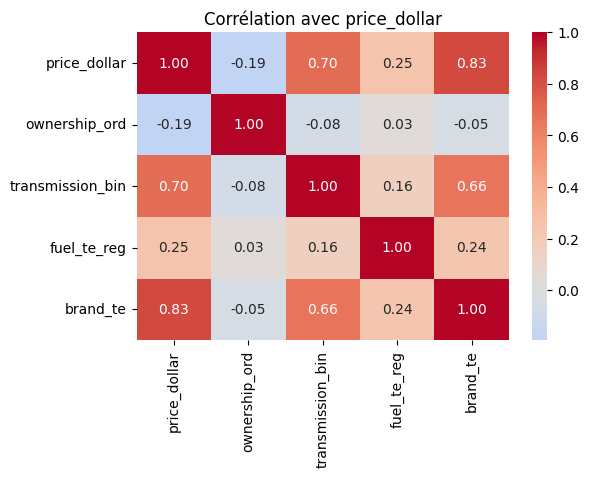

In [ ]:
# Plot correlation heatmap for the target and encoded features
plt.figure(figsize=(6, 4))
sns.heatmap(
    df[cols].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    center=0
)
plt.title("Corrélation avec price_dollar")
plt.show()

The correlation heatmap confirms that encoded categorical features brand and transmission variable
exhibit strong and interpretable relationships with the target variablev alidating the chosen encoding strategies.

In [75]:
columns_to_drop = [
    "car_name",
    "brand",
    "fuel_type",
    "transmission",
    "ownership"
]

df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

In [76]:
%store df

Stored 'df' (DataFrame)
